## Imports and utility functions

We need pytorch, numpy, and the code for the segmentation model.  And some utilities for visualizing the data.

In [1]:
# System libs
import os, csv, torch, numpy, scipy.io, PIL.Image, torchvision.transforms
# Our libs
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode
from collections import Counter
import matplotlib.pyplot as plt
import cv2

colors = scipy.io.loadmat('pretrained_seg_model/data/color150.mat')['colors']
names = {}
with open('pretrained_seg_model/data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')
        
    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # aggregate images and save
    im_vis = numpy.concatenate((img, pred_color), axis=1)
    display(PIL.Image.fromarray(im_vis))

#returns a list of coordinate tuples where each tuple is row, column with the found pixel
def find_predictions(pred, index, threshold):
    pred = pred.copy()
    pred[pred != index] = -1
    rows, cols = numpy.where(pred == index)
    pred_pixels = list(zip(rows, cols))

    # assuming our image is just the grid image of 4x4 images
    image_width = pred.shape[1] // 4 # the height and width of each image in the grid
    image_height = pred.shape[0] // 4
    selected_images = []
    for row, column in pred_pixels:
        image_row = int(row // image_height)
        image_col = int(column // image_width)
        selected_images.append((image_row, image_col))
    freqs = Counter(selected_images)
    filtered_images = []
    for image, count in freqs.most_common():
        if count >= threshold:
            filtered_images.append(image)
        else:
            break
    return filtered_images


    


## Loading the Captcha Type model

Here we load a pretrained Captcha Type model. 


In [2]:
import pickle
with open('captcha_type.pickle', 'rb') as file:
    captcha_type_model = pickle.load(file)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-06 15:58:15.679257: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-06 15:58:15.679352: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Loading the segmentation model

Here we load a pretrained segmentation model.  Like any pytorch model, we can call it like a function, or examine the parameters in all the layers.

After loading, we put it on the CPU.  And since we are doing inference, not training, we put the model in eval mode.

In [3]:
# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='pretrained_seg_model/ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights='pretrained_seg_model/ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()
segmentation_module.cpu()

Loading weights for net_encoder
Loading weights for net_decoder


SegmentationModule(
  (encoder): ResnetDilated(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): SynchronizedBatchNorm2d(128, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): SynchronizedBatchNorm2d(64, eps=1

## Load test data make predictions then visualize the results

Now we load and normalize a single test image.  Here we use the commonplace convention of normalizing the image to a scale for which the RGB values of a large photo dataset would have zero mean and unit standard deviation.  (These numbers come from the imagenet dataset.)  With this normalization, the limiiting ranges of RGB values are within about (-2.2 to +2.7).

1/1 [==============================] - 0s 171ms/step


2023-04-06 15:59:00.517065: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-06 15:59:00.573975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


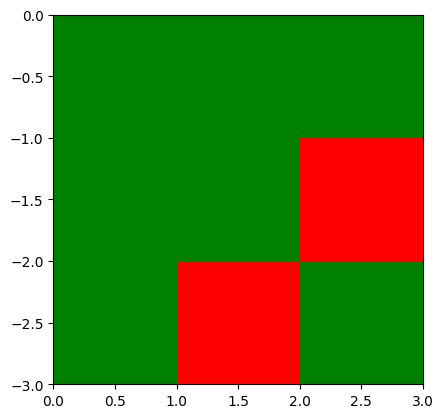

1/1 [==============================] - 0s 14ms/step


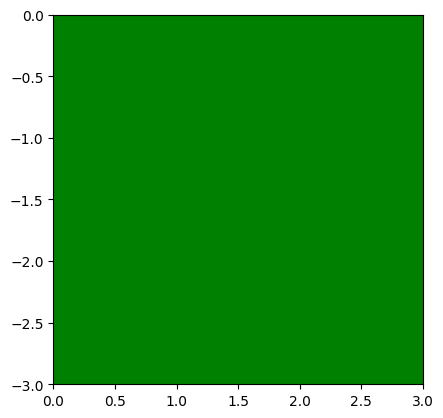

1/1 [==============================] - 0s 14ms/step


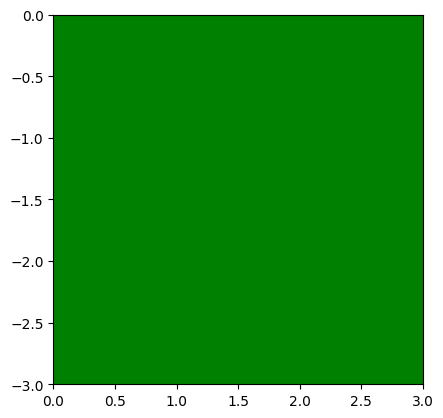

1/1 [==============================] - 0s 13ms/step


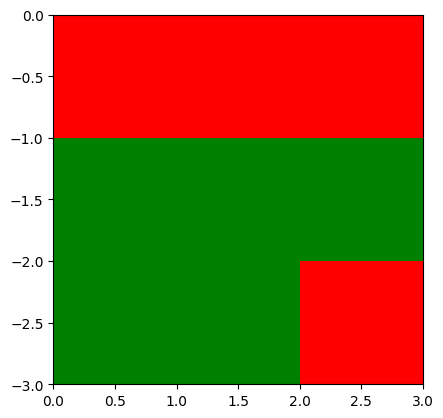

1/1 [==============================] - 0s 13ms/step


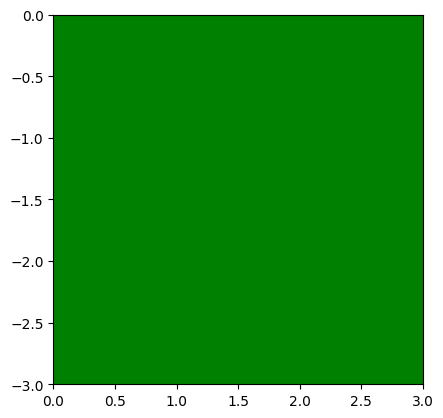

In [4]:
def visualize_matrix(matrix):
    # Create a figure and axis
    fig, ax = plt.subplots()
    # Loop through each element in the matrix
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            # If the element is 1, draw a green square
            if matrix[i][j] == 1:
                ax.add_patch(plt.Rectangle((j, -i-1), 1, 1, facecolor='green'))
            # If the element is 0, draw a red square
            else:
                ax.add_patch(plt.Rectangle((j, -i-1), 1, 1, facecolor='red'))

    # Set the x and y limits
    ax.set_xlim(0, len(matrix[0]))
    ax.set_ylim(-len(matrix), 0)

    # Set aspect ratio to 'equal' to make the squares square
    ax.set_aspect('equal')

    # Show the plot
    plt.show()


def solve_4(TARGET, pred, img_original):
    predicted_classes = numpy.bincount(pred.flatten()).argsort()[::-1]
    for c in predicted_classes:
        if names[c+1] == TARGET:
            to_select = find_predictions(pred, c, 5)
            solution_matrix = tuple_arr_to_matrix(to_select)
            #visualize_result(img_original, pred, c)
            return solution_matrix
    return []

def solve_3(TARGET, pred, img_original):
    predicted_classes = numpy.bincount(pred.flatten()).argsort()[::-1]
    for c in predicted_classes:
        if names[c+1] == TARGET:
            return True
    return False

def extract_subimages(img_data):
    """
    Extracts 9 subimages of size 100x100 from the original image data.

    Args:
        img_data (torch.Tensor): Original image data as a torch tensor of shape [3, 300, 300].

    Returns:
        List[torch.Tensor]: List of 9 subimages, each of size [3, 100, 100].
    """
    subimages = []
    for i in range(3):
        for j in range(3):
            subimage = img_data[:, i*100:(i+1)*100, j*100:(j+1)*100]
            subimages.append(subimage)
    return subimages


def decode_label(label):
    class_names = ['segmentation', 'letters', 'nonsegmentation']
    return class_names[label]

def fill_matrix(solution_matrix, index):
    if index < 3:
        solution_matrix[0][index] = 1
    elif index < 6:
        solution_matrix[1][index-3] = 1
    else:
        solution_matrix[2][index-6] = 1

def tuple_arr_to_matrix(array):
    matrix = [[0 for j in range(4)] for i in range(4)]
    for i, j in array:
        matrix[i][j] = 1

    return matrix
    

# Load and normalize one image as a singleton tensor batch
pil_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
        std=[0.229, 0.224, 0.225])  # across a large photo dataset.
])

directory = "captchas/input/"
image_list = []
original_imgs = []
targets = ["car", "road", "tree", "car", "tree"]

# loop through each file in the directory
for filename in sorted(os.listdir(directory)):
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"): # check if file is an image
        image_path = os.path.join(directory, filename)
        pil_image = PIL.Image.open(image_path).convert('RGB')
        img_original = numpy.array(pil_image)

        #create list of image objects and original images for vis
        image_list.append(pil_image) 
        original_imgs.append(img_original)


# Process each image in image_list
for i, pil_image in enumerate(image_list):

    #check the captcha type with our other model
    img = cv2.resize(original_imgs[i], (120, 120))
    img = numpy.expand_dims(img, axis=0)

    captcha_type = captcha_type_model.predict(img)
    
    pred_type = decode_label(numpy.argmax(captcha_type))

    
    if pred_type == "segmentation":
        img_data = pil_to_tensor(pil_image)
        singleton_batch = {'img_data': img_data[None].cpu()}
        output_size = img_data.shape[1:]
        # Run the segmentation at the highest resolution.
        with torch.no_grad():
            scores = segmentation_module(singleton_batch, segSize=output_size)
        # Get the predicted scores for each pixel
        _, pred = torch.max(scores, dim=1)
        pred = pred.cpu()[0].numpy()
        solution_matrix = solve_4(targets[i], pred, original_imgs[i])
        if len(solution_matrix) == 0:
            print("Class not found in Image")
        else:
            visualize_matrix(solution_matrix)
    elif pred_type == "nonsegmentation":
        #do non-segmented
        solution_matrix = [[0 for j in range(3)] for i in range(3)]
        img_data = pil_to_tensor(pil_image)
        individual_images = extract_subimages(img_data)
        idx = 0
        for image in individual_images:
            singleton_batch = {'img_data': image[None].cpu()}
            output_size = image.shape[1:]
                    # Run the segmentation at the highest resolution.
            with torch.no_grad():
                scores = segmentation_module(singleton_batch, segSize=output_size)
            # Get the predicted scores for each pixel
            _, pred = torch.max(scores, dim=1)
            pred = pred.cpu()[0].numpy()
            if solve_3(targets[i], pred, image):
                fill_matrix(solution_matrix, idx)
            idx +=1
        visualize_matrix(solution_matrix)
    else:
        print("here")
        #do letters

## Showing classes individually

To see which colors are which, here we visualize individual classes, one at a time.

In [5]:
print(names)

{1: 'wall', 2: 'building', 3: 'sky', 4: 'floor', 5: 'tree', 6: 'ceiling', 7: 'road', 8: 'bed', 9: 'windowpane', 10: 'grass', 11: 'cabinet', 12: 'sidewalk', 13: 'person', 14: 'earth', 15: 'door', 16: 'table', 17: 'mountain', 18: 'plant', 19: 'curtain', 20: 'chair', 21: 'car', 22: 'water', 23: 'painting', 24: 'sofa', 25: 'shelf', 26: 'house', 27: 'sea', 28: 'mirror', 29: 'rug', 30: 'field', 31: 'armchair', 32: 'seat', 33: 'fence', 34: 'desk', 35: 'rock', 36: 'wardrobe', 37: 'lamp', 38: 'bathtub', 39: 'railing', 40: 'cushion', 41: 'base', 42: 'box', 43: 'column', 44: 'signboard', 45: 'chest', 46: 'counter', 47: 'sand', 48: 'sink', 49: 'skyscraper', 50: 'fireplace', 51: 'refrigerator', 52: 'grandstand', 53: 'path', 54: 'stairs', 55: 'runway', 56: 'case', 57: 'pool', 58: 'pillow', 59: 'screen', 60: 'stairway', 61: 'river', 62: 'bridge', 63: 'bookcase', 64: 'blind', 65: 'coffee', 66: 'toilet', 67: 'flower', 68: 'book', 69: 'hill', 70: 'bench', 71: 'countertop', 72: 'stove', 73: 'palm', 74: '